# EOTDL ML-Inference

EOTDL offers a REST API for inference on some models.

In [62]:
import requests

url = f'https://ml-inference.api.eotdl.com/'
# url = f'http://localhost:8000/'
res = requests.get(url) 

res.status_code, res.json()

(200,
 {'message': 'Hello from the ml-inference API!',
  'version': '2025.09.23',
  'auth_required': False})

Let's detect some roads on an HR aerial image.

In [63]:
from IPython.display import JSON
import json

url = f'https://ml-inference.api.eotdl.com/RoadSegmentationQ2'
# url = f'http://localhost:8000/RoadSegmentationQ2'
res = requests.get(url) 

res.status_code
# res.json() # uncomment to see the model description (STAC metadata)

200

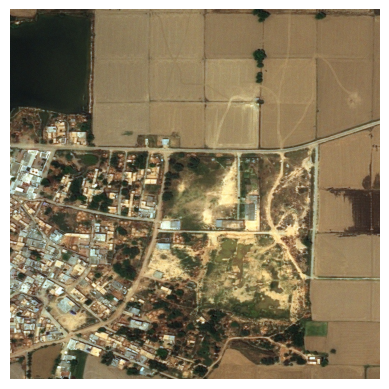

In [64]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = 'example_data/deep_globe.jpg' 

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [65]:
# inference
res = requests.post(url, files={'image': (open(img_path, 'rb'))})

if res.status_code != 200:
    print(res.json())
    
res.status_code

200

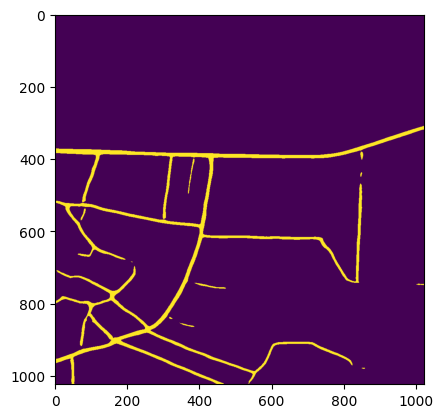

In [66]:
import numpy as np
import io 
from PIL import Image

# Assuming `response` is an image

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

image_bytes = io.BytesIO(res.content)
img = Image.open(image_bytes)

logits = np.array(img) 
probas = sigmoid(logits)
mask = probas > 0.5 # use different thresholds for sensitivity analysis
# mask = img

# plt.imshow(array)
plt.imshow(mask)
# array.shape, array.dtype, array.min(), array.max()

Let's try the model with a sentinel 2 image.

(146, 154, 3)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


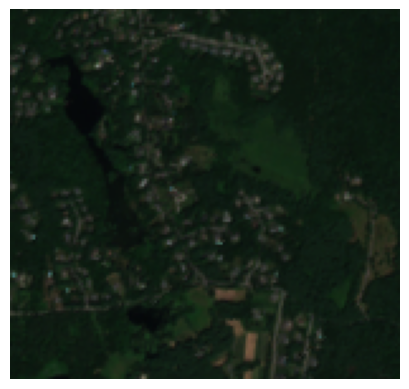

In [67]:
import rasterio as rio
from skimage.io import imsave

def tif2rgb(tif_path):
	x = rio.open(tif_path).read((4,3,2)) # read RGB bands
	# x = rio.open(tif_path).read((1,2,3)) # read RGB bands
	x = np.clip(x / 4000, 0, 1) # normalize to 0-1 with increased brightness
	x = (x * 255).astype(np.uint8) # convert to uint8
	x = x.transpose(1,2,0) # convert to HWC
	# x = resize(x, (256,256))
	# x = (x * 255).astype(np.uint8) # convert to uint8
	# crop
	# x = x[-512:,-512:,:]
	print(x.shape)
	new_path = tif_path.replace('.tiff', '.png')
	imsave(new_path, x)
	return new_path

img_path = tif2rgb('example_data/s2_roads.tiff')

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

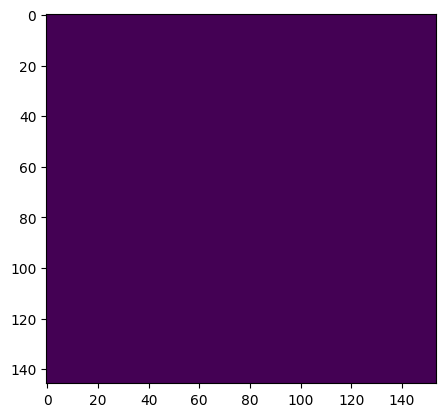

In [68]:
res = requests.post(url,  files={'image': (open(img_path, 'rb'))})

image_bytes = io.BytesIO(res.content)
mask = Image.open(image_bytes)

probas = np.array(mask) 
mask = probas > 0.3 # use different thresholds for sensitivity analysis

plt.imshow(mask)

Looks like this model is not the best for this task, let's try another one.

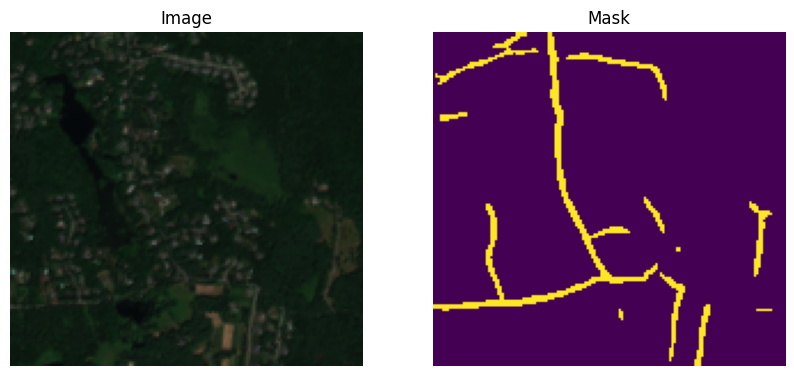

In [72]:
url = f'https://ml-inference.api.eotdl.com/MassachusettsRoadsS2Model'

res = requests.post(url,  files={'image': (open(img_path, 'rb'))})

image_bytes = io.BytesIO(res.content)
mask = Image.open(image_bytes)

probas = np.array(mask) 
mask = probas > 0.3 # use different thresholds for sensitivity analysis

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title('Image')
axs[0].axis('off')
axs[1].imshow(mask)
axs[1].set_title('Mask')
axs[1].axis('off')
plt.show()

In order for a model on EOTDL to be used thourgh the inference API, it must have supported STAC metadata with MLM extension.

Get in touch with us to add your model to the EOTDL inference API.